# Fundamentos de la Computación Cuántica - Tercera Entrega

Un multiplicador entre dos números binarios codificados en 3 qubits (mediante estados básicos), basado en dominio de Fourier

## Imports

In [78]:
import math
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

## Transformada Cuántica de Fourier Inversa (IQTF)

Por consiguiente, se plantea la transformada cuántica de Fourier inversa para N qubits.

![iqtf4.png](images/iqtf4.png)

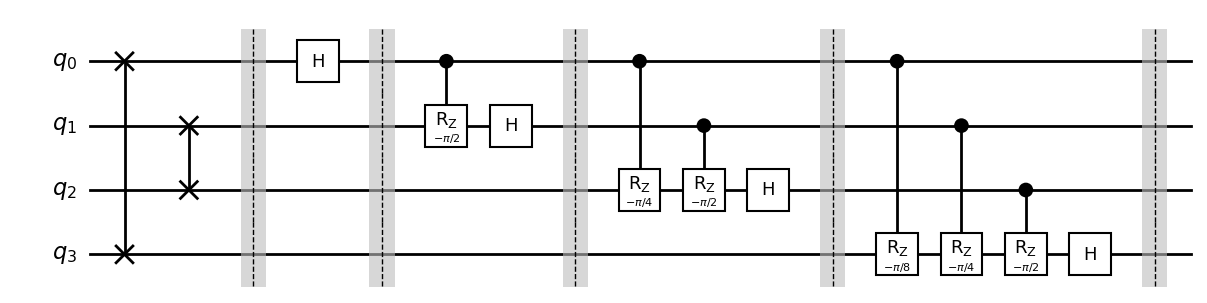

In [79]:
def iqtf(number_of_qubits):
    
    quantum_circuit = QuantumCircuit(number_of_qubits, name="IQTF")
    
    accesible_qubits = number_of_qubits - 1
    
    # Swap entre el qubit 0 y el n - 1.
    # Swap entre el qubit 1 y el n - 2.
    # Y así hasta llegar al centro.
    
    for i in range(int(number_of_qubits/2)):
        quantum_circuit.swap(i, accesible_qubits - i)
        
    quantum_circuit.barrier()
        
    # Por cada qubit, se aplica una rotación extra.
    # Al primer qubit, solo se le aplica Hadamard.
    # Al segundo, una rotación de pi/2 y Hadamard.
    # Al tercero, una rotación de pi/4, una rotación de pi/2 y Hadamard.
    for i in range(number_of_qubits):
        
        for j in range(i, 0, -1):
            # crz(angulo, control, objetivo)
            quantum_circuit.crz(-math.pi/(2 ** j), i - j, i)
        
        # Se aplica un Hadamard luego de las rotaciones.
        quantum_circuit.h(i)
        
        # Se aplica una barrera para evitar el autoordenamiento de Qiskit.
        quantum_circuit.barrier()
        
    return quantum_circuit
        
qc = iqtf(4)
qc.draw(output='mpl', style='bw')

## Multiplicador entre dos Números Binarios codificados en 3 qubits

El máximo número representable con 3 qubits es 7. El mayor valor obtenible de la multiplicación es 7 X 7 = 49. El cual puede representarse con seis qubits. 2^5 (32) + 2^4 (16) + 2^0 (1) = 110001. 